# simple 6D PS reconstruction

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.utils import split_2screen_dset
from phase_space_reconstruction.train import train_3d_scan_2screens

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from stats import plot_projections_with_contours

## Load data

In [16]:
# load data
#data_dir = '/global/cfs/cdirs/m669/rroussel/AWA_DATA/12-07_6D-PSR/reconstruction_scan'
data_dir = '/Users/jpga/AWA_DATA/01_16_6D_PSR/reconstruction_scan'
save_dir =  'results'
dset = torch.load(os.path.join(data_dir, 'dset_3d_01_16_full_scan_6.pt'))
# train_dset, test_dset = split_2screen_dset(dset)

In [17]:
from phase_space_reconstruction.modeling import ImageDataset3D

def clip_imgs(imgs, center, width):
    half_width = width // 2
    return imgs[Ellipsis, center-half_width:center+half_width, center-half_width:center+half_width]

def create_clipped_dset(dset, width):
    imgs = dset.images
    params = dset.params
    center = imgs.shape[-1] // 2
    clipped_imgs = clip_imgs(imgs, center, width)
    return ImageDataset3D(params, clipped_imgs)

In [18]:
clipped_dset = create_clipped_dset(dset, 500)
clipped_dset.images.shape

torch.Size([9, 2, 2, 3, 500, 500])

In [19]:
vmax1 = clipped_dset.images[4,0,0].max()
print(vmax1)
vmax2 = clipped_dset.images[4,0,1].max()
print(vmax2)

tensor(0.0020, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64)


In [20]:
def plot_3d_scan_data_2screens(dset, select_img = 'avg', vmax1=1, vmax2=1):
    if select_img == 'avg':
        imgs = dset.images.sum(dim=-3)
        imgs = imgs / dset.images.shape[-3]
    else:
        imgs = dset.images[:,:,:,select_img,:,:]
    params = dset.params
    n_k = params.shape[0]
    n_v = params.shape[1]
    n_g = params.shape[2]
    fig, ax = plt.subplots(
        n_v * n_g + 1,
        n_k + 1,
        figsize=( (n_k+1)*2, (n_v*n_g+1)*2 )
    )
    ax[0, 0].set_axis_off()
    ax[0, 0].text(1, 0, '$k_1$ (1/m$^2$)', va='bottom', ha='right')
    for i in range(n_k):
        ax[0, i + 1].set_axis_off()
        ax[0, i + 1].text(
            0.5, 0, f'{params[i, 0, 0, 0]:.1f}', va='bottom', ha='center'
        )
        for j in range(n_g):
            for k in range(n_v):
                if k == 0:
                    v_lbl = "off"
                else:
                    v_lbl = "on"
                if j == 0:
                    g_lbl = "off"
                    vmax = vmax1
                else:
                    vmax = vmax2
                    
                ax[2 * j + k + 1, i + 1].imshow(
                    imgs[i, k, j].T, 
                    origin='lower', 
                    interpolation='none',
                    vmin=0,
                    vmax=vmax
                )
                ax[2 * j + k + 1, i + 1].text(
                    0,0,imgs[i, k, j].sum()
                )
                ax[2 * j + k + 1, i + 1].tick_params(
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False
                )

                

                ax[2 * j + k + 1, 0].set_axis_off()
                ax[2 * j + k + 1, 0].text(
                    1, 0.5, f'T.D.C.: {v_lbl}\n DIPOLE: {g_lbl}',
                    va='center', ha='right'
                )

    return fig, ax

def get_beam_fraction_hist2d(hist2d, fraction: float):
    levels = np.linspace(hist2d.max(), 0.0, 100)
    total = hist2d.sum()
    final_beam = np.copy(hist2d)
    for level in levels:
        test_beam = np.where(hist2d>=level, hist2d, 0.0)
        test_frac = test_beam.sum() / total
        if test_frac > fraction:
            final_beam = test_beam
            break

    return final_beam

from scipy.ndimage import gaussian_filter

def plot_3d_scan_data_2screens_contour(
    pred_dset, 
    test_dset, 
    select_img = 'avg', 
    contour_percentiles = [50, 95],
    contour_smoothing_r = 1,
    contour_smoothing_gt = 1
):
    vmax = pred_dset.images.max()
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)
    pred_imgs = pred_dset.images[:,:,:,0,:,:]
    test_imgs = test_dset.images[:,:,:,0,:,:]
    if select_img == 'avg':
        test_imgs = test_dset.images.sum(dim=-3)
        test_imgs = test_imgs / test_imgs.shape[-3]
    else:
        test_imgs = test_dset.images[:,:,:,select_img,:,:]
        
    params = pred_dset.params
    n_k = params.shape[0]
    n_v = params.shape[1]
    n_g = params.shape[2]
    fig, ax = plt.subplots(
        n_v * n_g + 1,
        n_k + 1,
        figsize=( (n_k+1)*2, (n_v*n_g+1)*2 )
    )
    ax[0, 0].set_axis_off()
    ax[0, 0].text(1, 0, '$k_1$ (1/m$^2$)', va='bottom', ha='right')
    for i in range(n_k):
        ax[0, i + 1].set_axis_off()
        ax[0, i + 1].text(
            0.5, 0, f'{params[i, 0, 0, 0]:.1f}', va='bottom', ha='center'
        )
        for j in range(n_g):
            for k in range(n_v):
                ax[2 * j + k + 1, i + 1].imshow(
                    pred_imgs[i, k, j].T,
                    origin='lower', 
                    interpolation='none', 
                    vmin=0, 
                    vmax=vmax
                )
                for l, percentile in enumerate(contour_percentiles):
                    '''
                    h_r_fractions = get_beam_fraction_hist2d(pred_imgs[i, k, j], percentile/100)
                    ax[2 * j + k + 1, i + 1].contour(
                        #x_centers, 
                        #y_centers, 
                        #gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                        Z=h_r_fractions.T,
                        levels=[1],
                        linestyles="-",
                        colors=COLORS[l],
                        linewidths=1
                    )

                    h_gt_fractions = get_beam_fraction_hist2d(test_imgs[i,k,j], percentile/100)

                    ax[2 * j + k + 1, i + 1].contour(
                        #x_centers, 
                        #y_centers, 
                        #gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        Z=h_gt_fractions.T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[l],
                        linewidths=1
                    )  
                    '''
                    h_r_fractions = get_beam_fraction_hist2d(pred_imgs[i, k, j], percentile/100)
                    h_gt_fractions = get_beam_fraction_hist2d(test_imgs[i,k,j], percentile/100)
                    ax[2 * j + k + 1, i + 1].contour(
                        #h_r_fractions.T,
                        gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                        levels=[0],
                        linestyles="-",
                        colors=COLORS[l],
                        linewidths=1
                    )  
                    ax[2 * j + k + 1, i + 1].contour(
                        #h_gt_fractions.T,
                        gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        levels=[0],
                        linestyles="--",
                        colors=COLORS[l],
                        linewidths=1
                    ) 
                ax[2 * j + k + 1, i + 1].tick_params(
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False
                )

                if k == 0:
                    v_lbl = "off"
                else:
                    v_lbl = "on"
                if j == 0:
                    g_lbl = "off"
                else:
                    g_lbl = "on"

                ax[2 * j + k + 1, 0].set_axis_off()
                ax[2 * j + k + 1, 0].text(
                    1, 0.5, f'T.D.C.: {v_lbl}\n DIPOLE: {g_lbl}',
                    va='center', ha='right'
                )

    return fig, ax

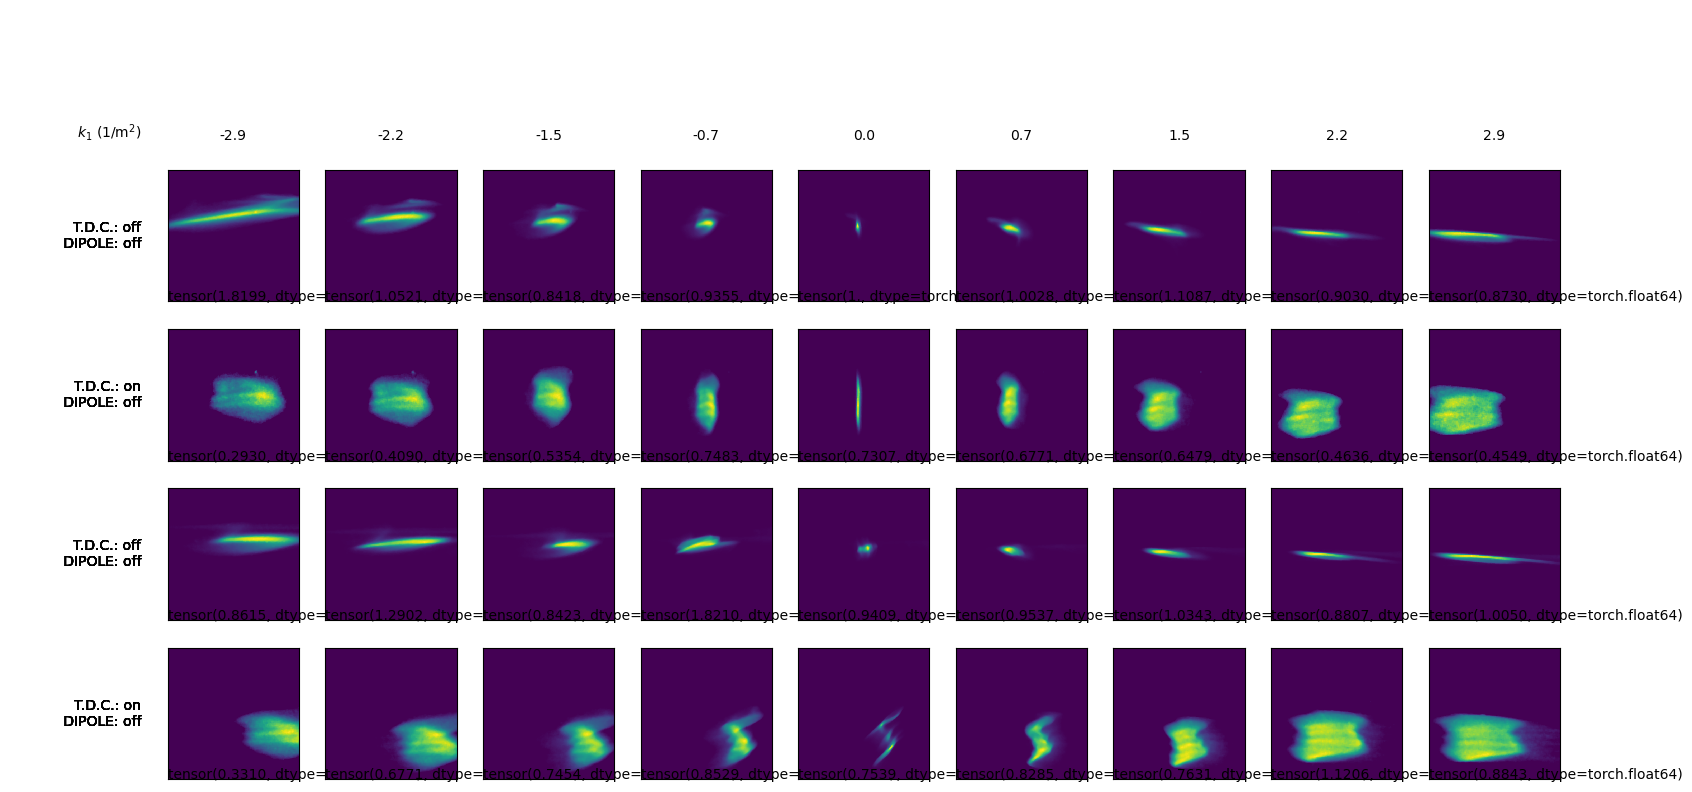

In [23]:
#plot_3d_scan_data_2screens(clipped_dset, select_img='avg',vmax1=vmax1, vmax2=vmax2)
plot_3d_scan_data_2screens(clipped_dset, select_img=2,vmax1=None, vmax2=None)
plt.show()

In [8]:
train_dset, test_dset = split_2screen_dset(clipped_dset)

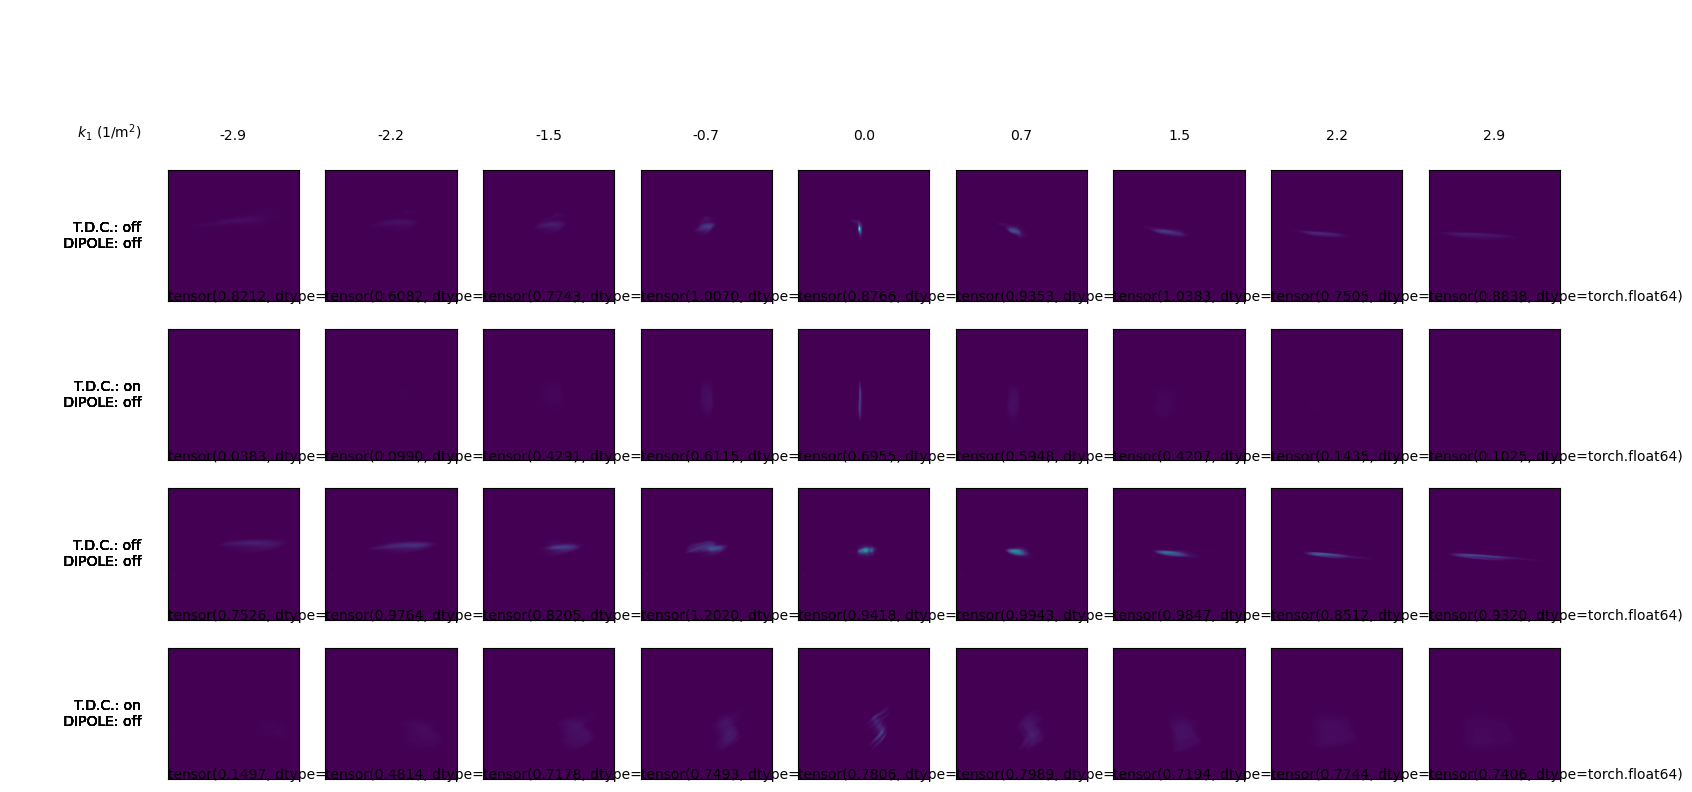

In [9]:
plot_3d_scan_data_2screens(dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

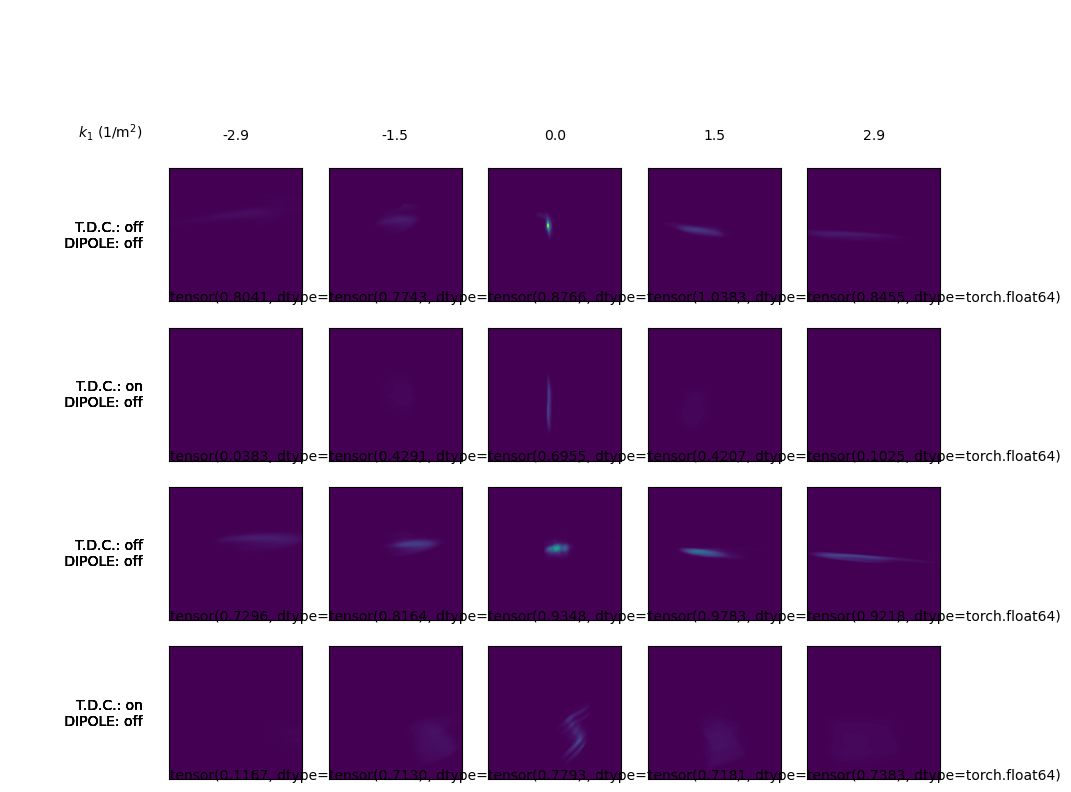

In [10]:
plot_3d_scan_data_2screens(train_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

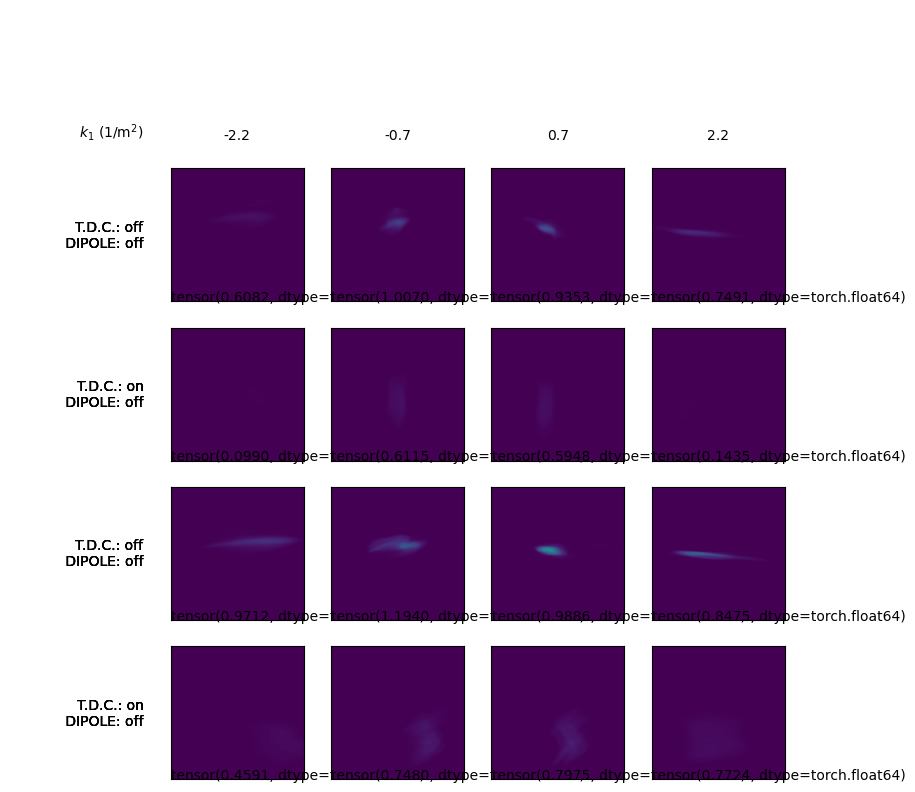

In [11]:
plot_3d_scan_data_2screens(test_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

## Define diagnostics lattice parameters

In [ ]:
# diagnostic beamline:
p0c = 62.0e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)

screen0 = create_screen(30.22*1e-3, 700)
screen1 = create_screen(26.96*1e-3, 700)

### 10,000 particles

In [ ]:
%%time

# training
pred_beam = train_3d_scan_2screens(
    train_dset, 
    lattice0,
    lattice1, 
    p0c, 
    screen0,
    screen1,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 100_000, 
    device = 'cuda'
    )
pred_beam = pred_beam.numpy_particles()
torch.cuda.empty_cache()

In [ ]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam,
                           #custom_lims = lims,
                           bins = 50
                           )
plt.show()

In [ ]:
torch.save(pred_beam, 'pred_beam.pt')